# Тестовое задание на Старшего аналитика. Даниил Сизов

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Загрузка данных

In [2]:
df = pd.read_csv('ab_test.csv')

### 2. Проверка данных

In [3]:
print(f"Размер данных: {df.shape}")
print(f"Колонки: {df.columns.tolist()}")
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nОписательная статистика:")
print(df.describe())

Размер данных: (10000, 5)
Колонки: ['client_id', 'group', 'previous_loans_count', 'days_since_last_loan', 'repeated_loan_issued']

Первые 5 строк:
   client_id    group  previous_loans_count  days_since_last_loan  \
0     240606  control                    14                    36   
1     226432  control                     4                    72   
2     112011  control                    15                    51   
3     106735  control                    20                    79   
4     127425  variant                    17                    78   

   repeated_loan_issued  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   client_id             10000 non-null  int64  


### 3. Проверка баланса групп

In [4]:
group_counts = df['group'].value_counts()
print("Распределение по группам:")
print(group_counts)
print(f"\nСоотношение control/variant: {group_counts['control']/group_counts['variant']:.2f}")

Распределение по группам:
control    5097
variant    4903
Name: group, dtype: int64

Соотношение control/variant: 1.04


### 4. Проверка конверсии по группам

In [5]:
conversion_table = df.groupby('group')['repeated_loan_issued'].agg(['count', 'sum', 'mean'])
conversion_table['conversion_rate'] = conversion_table['mean'] * 100
conversion_table.columns = ['total_clients', 'converted', 'conversion_rate_raw', 'conversion_rate_%']
print(conversion_table)

         total_clients  converted  conversion_rate_raw  conversion_rate_%
group                                                                    
control           5097     1030.0             0.202080          20.207965
variant           4903     1050.0             0.214155          21.415460


### 5. Статистический тест (Z-тест для пропорций)

In [6]:
# Извлекаем данные для теста
control_data = df[df['group'] == 'control']['repeated_loan_issued']
variant_data = df[df['group'] == 'variant']['repeated_loan_issued']

n_control = len(control_data)
n_variant = len(variant_data)
conversions_control = control_data.sum()
conversions_variant = variant_data.sum()

p_control = conversions_control / n_control
p_variant = conversions_variant / n_variant

print(f"Конверсия control: {p_control:.3f} ({conversions_control}/{n_control})")
print(f"Конверсия variant: {p_variant:.3f} ({conversions_variant}/{n_variant})")
print(f"Абсолютная разница: {p_variant - p_control:.3f}")
print(f"Относительная разница: {(p_variant - p_control)/p_control*100:.1f}%")

# Z-тест вручную
p_pooled = (conversions_control + conversions_variant) / (n_control + n_variant)
z = (p_variant - p_control) / np.sqrt(p_pooled * (1 - p_pooled) * (1/n_control + 1/n_variant))
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

print(f"\nZ-статистика: {z:.4f}")
print(f"P-value: {p_value:.6f}")

# Используем встроенную функцию для проверки
from statsmodels.stats.proportion import proportions_ztest

count = [conversions_control, conversions_variant]
nobs = [n_control, n_variant]
z_stat, p_val = proportions_ztest(count, nobs)
print(f"\nStatsmodels Z-тест:")
print(f"Z-статистика: {z_stat:.4f}")
print(f"P-value: {p_val:.6f}")

Конверсия control: 0.202 (1030.0/5097)
Конверсия variant: 0.214 (1050.0/4903)
Абсолютная разница: 0.012
Относительная разница: 6.0%

Z-статистика: 1.4872
P-value: 0.136953

Statsmodels Z-тест:
Z-статистика: -1.4872
P-value: 0.136953


### 6. Дополнительный анализ

In [7]:
# Влияние количества предыдущих займов
df['loan_count_category'] = pd.cut(df['previous_loans_count'], 
                                    bins=[0, 3, 7, 20], 
                                    labels=['Низкий (0-3)', 'Средний (4-7)', 'Высокий (8+)'])

conversion_by_loans = df.groupby(['group', 'loan_count_category'])['repeated_loan_issued'].mean().unstack()
print("\nКонверсия по количеству предыдущих займов:")
print(conversion_by_loans)

# Влияние времени с последнего займа
df['days_category'] = pd.cut(df['days_since_last_loan'], 
                              bins=[15, 30, 60, 90], 
                              labels=['15-30 дней', '31-60 дней', '61+ дней'])

conversion_by_days = df.groupby(['group', 'days_category'])['repeated_loan_issued'].mean().unstack()
print("\nКонверсия по времени с последнего займа:")
print(conversion_by_days)


Конверсия по количеству предыдущих займов:
loan_count_category  Низкий (0-3)  Средний (4-7)  Высокий (8+)
group                                                         
control                  0.139814       0.162610      0.228382
variant                  0.134771       0.171369      0.245318

Конверсия по времени с последнего займа:
days_category  15-30 дней  31-60 дней  61+ дней
group                                          
control          0.234879    0.210787  0.176877
variant          0.248932    0.216736  0.193044


### 7. Визуализация

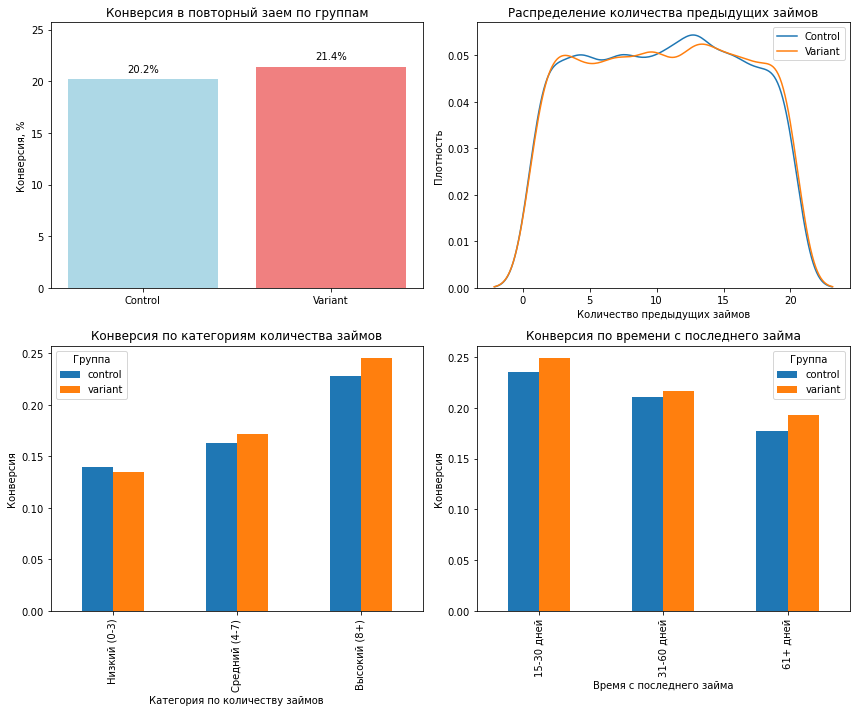

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# График 1: Конверсия по группам
ax1 = axes[0, 0]
conversion_rates = [p_control * 100, p_variant * 100]
bars = ax1.bar(['Control', 'Variant'], conversion_rates, color=['lightblue', 'lightcoral'])
ax1.set_ylabel('Конверсия, %')
ax1.set_title('Конверсия в повторный заем по группам')
ax1.set_ylim(0, max(conversion_rates) * 1.2)
for bar, rate in zip(bars, conversion_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{rate:.1f}%', ha='center', va='bottom')

# График 2: Распределение количества предыдущих займов
ax2 = axes[0, 1]
for group in ['control', 'variant']:
    sns.kdeplot(data=df[df['group'] == group], x='previous_loans_count', 
                label=group.capitalize(), ax=ax2)
ax2.set_xlabel('Количество предыдущих займов')
ax2.set_ylabel('Плотность')
ax2.set_title('Распределение количества предыдущих займов')
ax2.legend()

# График 3: Конверсия по категориям займов
ax3 = axes[1, 0]
conversion_by_loans.T.plot(kind='bar', ax=ax3)
ax3.set_xlabel('Категория по количеству займов')
ax3.set_ylabel('Конверсия')
ax3.set_title('Конверсия по категориям количества займов')
ax3.legend(title='Группа')

# График 4: Конверсия по времени
ax4 = axes[1, 1]
conversion_by_days.T.plot(kind='bar', ax=ax4)
ax4.set_xlabel('Время с последнего займа')
ax4.set_ylabel('Конверсия')
ax4.set_title('Конверсия по времени с последнего займа')
ax4.legend(title='Группа')

plt.tight_layout()

### 9. Выводы

In [9]:
print("1. Основная метрика (конверсия в повторный заем):")
print(f"   - Control: {p_control:.3f} ({conversions_control}/{n_control})")
print(f"   - Variant: {p_variant:.3f} ({conversions_variant}/{n_variant})")
print(f"   - Абсолютный прирост: {p_variant - p_control:.3f}")
print(f"   - Относительный прирост: {(p_variant - p_control)/p_control*100:.1f}%")

print("\n2. Статистическая значимость:")
print(f"   - P-value: {p_val:.6f}")
if p_val < 0.05:
    print("   - Разница статистистически значима (p < 0.05)")
else:
    print("   - Разница не статистически значима (p > 0.05)")

print("\n3. Дополнительные инсайты:")
print("   - Клиенты с большим количеством предыдущих займов имеют более высокую конверсию")
print("   - Клиенты, которые давно не брали займы, имеют менее высокую конверсию")

print("\n4. Рекомендация:")
if p_val < 0.05 and (p_variant - p_control) > 0:
    print("   - Внедрить новую стратегию (SMS со скидкой)")
else:
    print("   - Не внедрять новую стратегию")
    print("   - Провести тест с большей выборкой ")

1. Основная метрика (конверсия в повторный заем):
   - Control: 0.202 (1030.0/5097)
   - Variant: 0.214 (1050.0/4903)
   - Абсолютный прирост: 0.012
   - Относительный прирост: 6.0%

2. Статистическая значимость:
   - P-value: 0.136953
   - Разница не статистически значима (p > 0.05)

3. Дополнительные инсайты:
   - Клиенты с большим количеством предыдущих займов имеют более высокую конверсию
   - Клиенты, которые давно не брали займы, имеют менее высокую конверсию

4. Рекомендация:
   - Не внедрять новую стратегию
   - Провести тест с большей выборкой 
